In [1]:
PATH = './'

In [2]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gg5odlry
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gg5odlry


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

In [4]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [5]:
X = sorted(glob.glob(PATH + 'Water Bodies Dataset/Images/*'))
y = sorted(glob.glob(PATH + 'Water Bodies Dataset/Masks/*'))

In [6]:
len(y)

2841

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

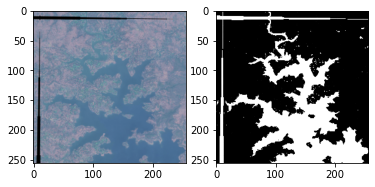

In [9]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [10]:
DEVICE='cuda'

EPOCHS=25
BATCH_SIZE=8
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=5

ENCODER='resnet50'
WEIGHTS='imagenet'

In [11]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [12]:
len(valid_loader)

36

In [13]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

Defaulting to user installation because normal site-packages is not writeable


In [14]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

#         self.arc=smp.Unet(
#             encoder_name=ENCODER,
#             encoder_weights=WEIGHTS,
#             in_channels=3,
#             classes=1,
#             activation=None
#         )
    
        self.arc = FCN32(n_class=1).copy_params_from_vgg16(vgg16)
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [14]:
import torch.nn as nn

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=12):
        super(FCN32s, self).__init__()
        
        # YOUR CODE HERE
        
        self.conv1_1 = nn.Conv2d(3,64,kernel_size=3,padding=100,stride=1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv2_1 = nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1,stride=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv3_1 = nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv4_1 = nn.Conv2d(256,512,kernel_size=3,padding=1,stride=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv5_1 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.fc6 = nn.Conv2d(512,4096,kernel_size=7,stride=1,padding=0)
        self.fc6_relu = nn.ReLU()
        self.fc6_dropout = nn.Dropout2d()
        
        self.fc7 = nn.Conv2d(4096,4096,kernel_size=1,stride=1,padding=0)
        self.fc7_relu = nn.ReLU()
        self.fc7_dropout = nn.Dropout2d()
        
        self.score = nn.Conv2d(4096,n_class,kernel_size=1,stride=1,padding=0)
        self.transpose_conv = nn.ConvTranspose2d(n_class,n_class,kernel_size=64,stride=32,bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.zero_()
#                 if m.bias is not None:
#                     m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):

        ################################################################################
        # TODO: Implement the forward pass for FCN32s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = self.conv1_1(x)
        out = self.relu1_1(out)
        out = self.conv1_2(out)
        out = self.relu1_2(out)
        out = self.pool1(out)
        
        out = self.conv2_1(out)
        out = self.relu2_1(out)
        out = self.conv2_2(out)
        out = self.relu2_2(out)
        out = self.pool2(out)
        
        out = self.conv3_1(out)
        out = self.relu3_1(out)
        out = self.conv3_2(out)
        out = self.relu3_2(out)
        out = self.conv3_3(out)
        out = self.relu3_3(out)
        out = self.pool3(out)
        
        out = self.conv4_1(out)
        out = self.relu4_1(out)
        out = self.conv4_2(out)
        out = self.relu4_2(out)
        out = self.conv4_3(out)
        out = self.relu4_3(out)
        out = self.pool4(out)
        
        out = self.conv5_1(out)
        out = self.relu5_1(out)
        out = self.conv5_2(out)
        out = self.relu5_2(out)
        out = self.conv5_3(out)
        out = self.relu5_3(out)
        out = self.pool5(out)
        
        out = self.fc6(out)
        out = self.fc6_relu(out)
        out = self.fc6_dropout(out)
        
        out = self.fc7(out)
        out = self.fc7_relu(out)
        out = self.fc7_dropout(out)
        
        out = self.score(out)
        out = self.transpose_conv(out)
        
        x_size = x.size()
        h = out[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])]
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        
        return h

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


In [36]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

#         self.arc=smp.Unet(
#             encoder_name=ENCODER,
#             encoder_weights=WEIGHTS,
#             in_channels=3,
#             classes=1,
#             activation=None
#         )
    
        self.arc = FCN32s(n_class=1)
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [37]:
model=SegmentationModel()
model.arc.copy_params_from_vgg16(vgg16)
model.to(DEVICE)


SegmentationModel(
  (arc): FCN32s(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (relu1_1): ReLU()
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU()
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU()
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU()
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3): ReLU()
    (pool3): MaxPool2d(kernel_size=(2

In [15]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    total_iou = 0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        pred_mask=torch.sigmoid(logits)
        pred_mask=(pred_mask > ratio)*1.0
        total_iou += calculate_iou(pred_mask, masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader),total_iou/len(data_loader)

In [16]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    total_iou = 0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)
            logits,diceloss,bceloss=model(images,masks)
            pred_mask=torch.sigmoid(logits)
            pred_mask=(pred_mask > ratio)*1.0
            #pred_mask = pred_mask.detach().cpu().numpy()
            #masks = masks.detach().cpu().numpy()
            total_iou += calculate_iou(pred_mask, masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
        
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    
    #print('IoU score:', total_iou/len(data_loader))
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader),total_iou/len(data_loader)

In [20]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

device cuda


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


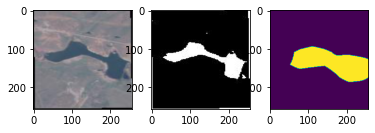

Epochs:1
Train_loss --> Dice: 0.35333825312554834 BCE: 0.4081163084134459 
Valid_loss --> Dice: 0.3154326577981313 BCE: 0.36087747166554135
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


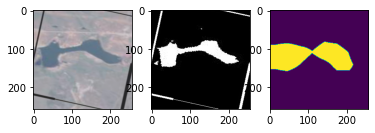

Epochs:2
Train_loss --> Dice: 0.3148843105882406 BCE: 0.3740469815675169 
Valid_loss --> Dice: 0.2906494869126214 BCE: 0.3397837525440587
Model Saved


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


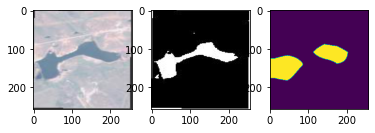

Epochs:3
Train_loss --> Dice: 0.29845429603010415 BCE: 0.35034110555425285 
Valid_loss --> Dice: 0.29131899277369183 BCE: 0.3136683930125501
Model Saved


100%|██████████| 36/36 [00:12<00:00,  2.87it/s]


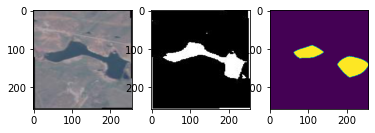

Epochs:4
Train_loss --> Dice: 0.28100644834339616 BCE: 0.34100002599880097 
Valid_loss --> Dice: 0.29240171280172134 BCE: 0.31025566905736923
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.60it/s]


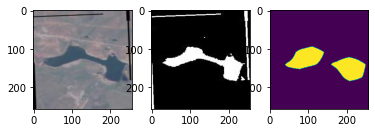

Epochs:5
Train_loss --> Dice: 0.27008231952786443 BCE: 0.3276511773467064 
Valid_loss --> Dice: 0.2791477855708864 BCE: 0.3068511171473397
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.74it/s]


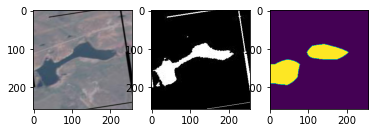

Epochs:6
Train_loss --> Dice: 0.259229351952672 BCE: 0.31445321068167686 
Valid_loss --> Dice: 0.26650289860036636 BCE: 0.30213179397914147
Model Saved


100%|██████████| 36/36 [00:10<00:00,  3.37it/s]


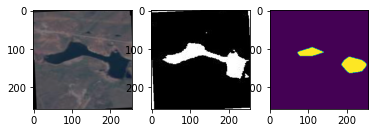

Epochs:7
Train_loss --> Dice: 0.25921654235571623 BCE: 0.3137665051966906 
Valid_loss --> Dice: 0.3427554451757007 BCE: 0.37086962742937934


100%|██████████| 36/36 [00:09<00:00,  3.81it/s]


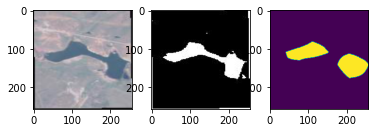

Epochs:8
Train_loss --> Dice: 0.2503714831545949 BCE: 0.3020889944396913 
Valid_loss --> Dice: 0.24787246849801806 BCE: 0.3009440762301286
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.74it/s]


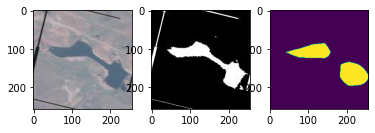

Epochs:9
Train_loss --> Dice: 0.25052280221134426 BCE: 0.3037548661697656 
Valid_loss --> Dice: 0.26580971976121265 BCE: 0.2892690656913651
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


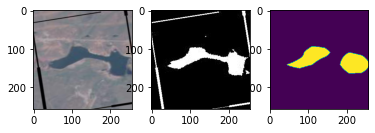

Epochs:10
Train_loss --> Dice: 0.24233640786260366 BCE: 0.2916774058714509 
Valid_loss --> Dice: 0.2452816516160965 BCE: 0.31143909237451023
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.78it/s]


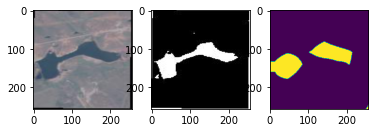

Epochs:11
Train_loss --> Dice: 0.24044465757906436 BCE: 0.29247991195879874 
Valid_loss --> Dice: 0.2500099407302009 BCE: 0.2917233759330379
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.62it/s]


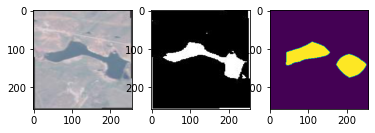

Epochs:12
Train_loss --> Dice: 0.2403696095570922 BCE: 0.2909832312259823 
Valid_loss --> Dice: 0.25003217657407123 BCE: 0.2864300207131439
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.75it/s]


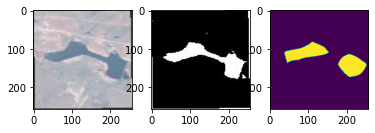

Epochs:13
Train_loss --> Dice: 0.22962117455899717 BCE: 0.2787680519744754 
Valid_loss --> Dice: 0.24750815828641257 BCE: 0.28589385706517434
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


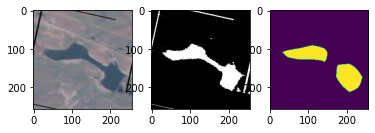

Epochs:14
Train_loss --> Dice: 0.2298443431034684 BCE: 0.2772802802734077 
Valid_loss --> Dice: 0.2434882852766249 BCE: 0.27758295254574883
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


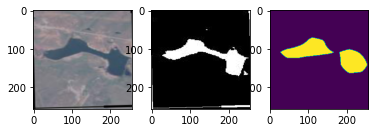

Epochs:15
Train_loss --> Dice: 0.22285198271274567 BCE: 0.2716656422242522 
Valid_loss --> Dice: 0.240580709444152 BCE: 0.29381277991665733
Model Saved


100%|██████████| 36/36 [00:10<00:00,  3.53it/s]


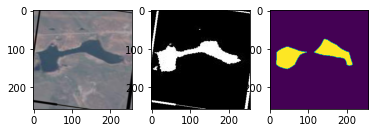

Epochs:16
Train_loss --> Dice: 0.22361881360411645 BCE: 0.2729314134456217 
Valid_loss --> Dice: 0.2506038612789578 BCE: 0.3025340706937843


100%|██████████| 36/36 [00:10<00:00,  3.50it/s]


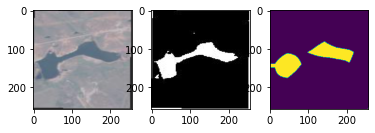

Epochs:17
Train_loss --> Dice: 0.21716811936348676 BCE: 0.26703047431074084 
Valid_loss --> Dice: 0.2405124737156762 BCE: 0.2709337919950485
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.73it/s]


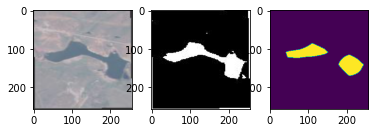

Epochs:18
Train_loss --> Dice: 0.21351339090615512 BCE: 0.2608015242032707 
Valid_loss --> Dice: 0.24052882194519043 BCE: 0.31595977188812363


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


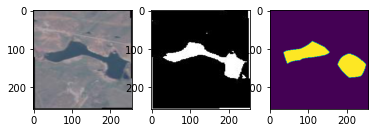

Epochs:19
Train_loss --> Dice: 0.2183332175016403 BCE: 0.2655360035132617 
Valid_loss --> Dice: 0.2387466248538759 BCE: 0.2775793733696143
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.80it/s]


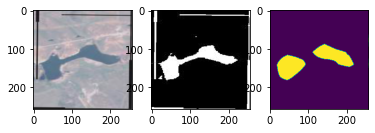

Epochs:20
Train_loss --> Dice: 0.2121559666469693 BCE: 0.25805148486979307 
Valid_loss --> Dice: 0.23802118996779123 BCE: 0.28089823987748885
Model Saved


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


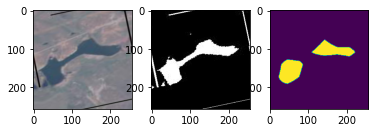

Epochs:21
Train_loss --> Dice: 0.21086214426904917 BCE: 0.2552013639127836 
Valid_loss --> Dice: 0.23992911809020573 BCE: 0.28139692669113475


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


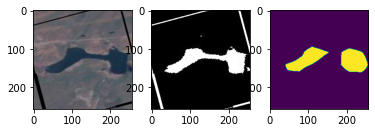

Epochs:22
Train_loss --> Dice: 0.20975044202059506 BCE: 0.25367832076735797 
Valid_loss --> Dice: 0.24189137584633297 BCE: 0.2792060478693909
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


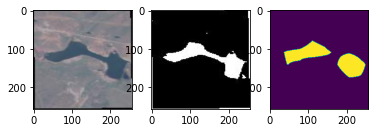

Epochs:23
Train_loss --> Dice: 0.20722829531878234 BCE: 0.25258471495471896 
Valid_loss --> Dice: 0.2376385529836019 BCE: 0.28583987471130157
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


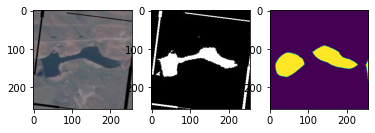

Epochs:24
Train_loss --> Dice: 0.20665570963174104 BCE: 0.25205435273237525 
Valid_loss --> Dice: 0.24542258348729876 BCE: 0.28435462216536206
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


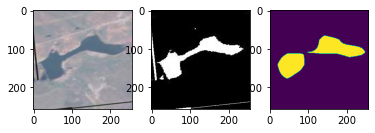

Epochs:25
Train_loss --> Dice: 0.20136856958270072 BCE: 0.24673165208660067 
Valid_loss --> Dice: 0.22481582396560246 BCE: 0.2791658644047048
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


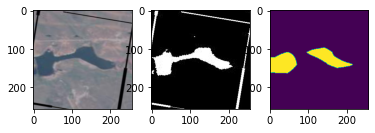

Epochs:26
Train_loss --> Dice: 0.20191524606198072 BCE: 0.24570569386705757 
Valid_loss --> Dice: 0.25653325352403855 BCE: 0.2990213640862041


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


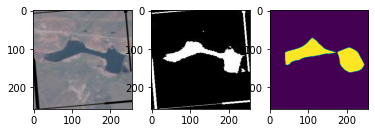

Epochs:27
Train_loss --> Dice: 0.20315443072468042 BCE: 0.2464350989088416 
Valid_loss --> Dice: 0.22766102188163334 BCE: 0.276746217161417
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.72it/s]


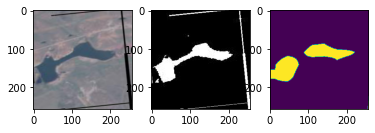

Epochs:28
Train_loss --> Dice: 0.1985775578767061 BCE: 0.241462183278054 
Valid_loss --> Dice: 0.23637432853380838 BCE: 0.2830457012686465


100%|██████████| 36/36 [00:09<00:00,  3.81it/s]


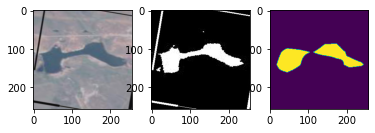

Epochs:29
Train_loss --> Dice: 0.19549356792122125 BCE: 0.23923930092714726 
Valid_loss --> Dice: 0.23113584849569532 BCE: 0.2953227882583936


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


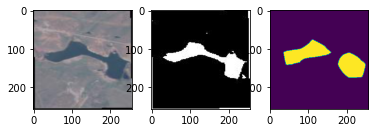

Epochs:30
Train_loss --> Dice: 0.19715575613081454 BCE: 0.2411426195409149 
Valid_loss --> Dice: 0.22737927072578007 BCE: 0.2774370134704643
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.74it/s]


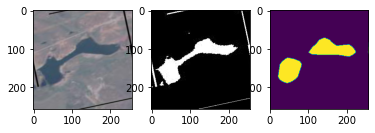

Epochs:31
Train_loss --> Dice: 0.196679731272161 BCE: 0.23843960862141103 
Valid_loss --> Dice: 0.224213977654775 BCE: 0.2822462713552846
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


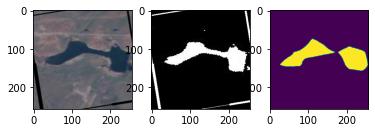

Epochs:32
Train_loss --> Dice: 0.19819877166301011 BCE: 0.24240409075282515 
Valid_loss --> Dice: 0.23072996570004356 BCE: 0.28305921372440124


100%|██████████| 36/36 [00:09<00:00,  3.77it/s]


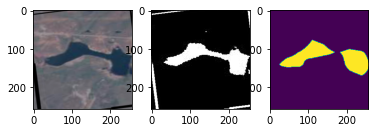

Epochs:33
Train_loss --> Dice: 0.1935563774779439 BCE: 0.23544434227515013 
Valid_loss --> Dice: 0.22940964500109354 BCE: 0.285719638897313


100%|██████████| 36/36 [00:09<00:00,  3.81it/s]


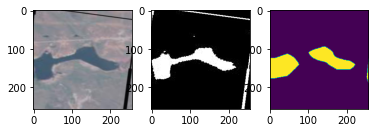

Epochs:34
Train_loss --> Dice: 0.19945172872394323 BCE: 0.24536672884132713 
Valid_loss --> Dice: 0.23909808695316315 BCE: 0.2705923459596104
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


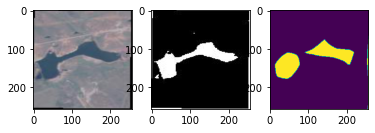

Epochs:35
Train_loss --> Dice: 0.19121401328593493 BCE: 0.2325389374047518 
Valid_loss --> Dice: 0.2159040305349562 BCE: 0.27348600948850316
Model Saved


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


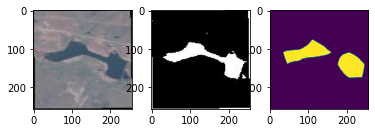

Epochs:36
Train_loss --> Dice: 0.18684020228683948 BCE: 0.22861682232469321 
Valid_loss --> Dice: 0.22717977066834769 BCE: 0.2871289509865973


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


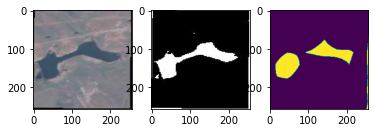

Epochs:37
Train_loss --> Dice: 0.19021672215312718 BCE: 0.2319546237587929 
Valid_loss --> Dice: 0.23658198946052128 BCE: 0.31434231748183566


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


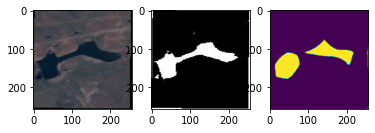

Epochs:38
Train_loss --> Dice: 0.18627092707902193 BCE: 0.22836883128620683 
Valid_loss --> Dice: 0.22736468414465585 BCE: 0.28770560895403224


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


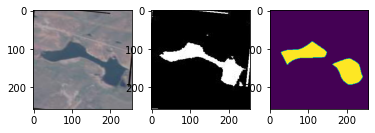

Epochs:39
Train_loss --> Dice: 0.18593640252947807 BCE: 0.22555286893621088 
Valid_loss --> Dice: 0.22958463264836204 BCE: 0.28478095390730435


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


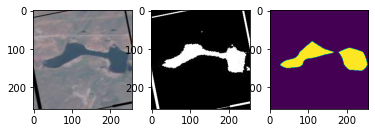

Epochs:40
Train_loss --> Dice: 0.18815872296690941 BCE: 0.22855891014914959 
Valid_loss --> Dice: 0.23205014069875082 BCE: 0.3038300524155299


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


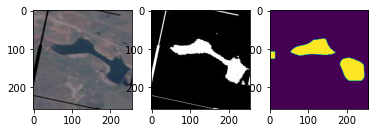

Epochs:41
Train_loss --> Dice: 0.1884698709473014 BCE: 0.22821721355430782 
Valid_loss --> Dice: 0.23447549011972216 BCE: 0.2796573109096951


100%|██████████| 36/36 [00:09<00:00,  3.76it/s]


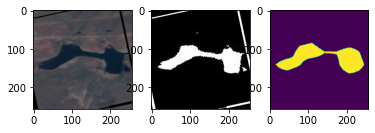

Epochs:42
Train_loss --> Dice: 0.18465563636273147 BCE: 0.2227490840246901 
Valid_loss --> Dice: 0.21845990419387817 BCE: 0.2779849987063143


100%|██████████| 36/36 [00:09<00:00,  3.61it/s]


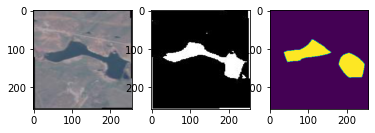

Epochs:43
Train_loss --> Dice: 0.1825062334537506 BCE: 0.2233374732779339 
Valid_loss --> Dice: 0.22001549104849497 BCE: 0.3002307042479515


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


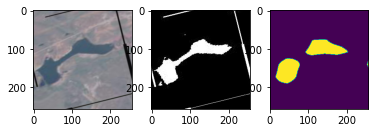

Epochs:44
Train_loss --> Dice: 0.179773804359138 BCE: 0.2210288138827309 
Valid_loss --> Dice: 0.22463459107610914 BCE: 0.28736431938078666


100%|██████████| 36/36 [00:09<00:00,  3.66it/s]


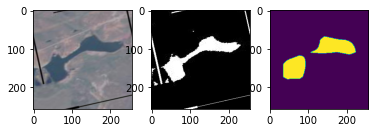

Epochs:45
Train_loss --> Dice: 0.18100706320255994 BCE: 0.22112945523113012 
Valid_loss --> Dice: 0.22242362797260284 BCE: 0.28117897568477523


In [28]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

In [29]:
torch.save(model.state_dict(),'best_model_45.pt')

In [34]:
image,mask=valid_loader.dataset[2]

torch.Size([3, 256, 256])


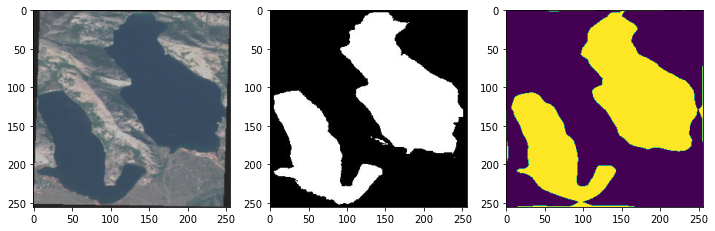

In [35]:
num=0
ratio=0.5

model=SegmentationModel().to(DEVICE)
model.load_state_dict(torch.load('./best_model_fcn8s_no_vgg_45.pt'))

#image,mask=valid_loader.dataset[2]
#image=image[num]
#mask=mask[num]
print(image.shape)
logits_mask,_,_=model(image.to('cuda', dtype=torch.float32).unsqueeze(0),mask.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3, figsize = (12,12)) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))

100%|██████████| 36/36 [00:06<00:00,  5.44it/s]


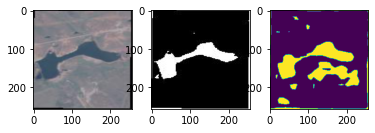

(0.34179820285903084, 0.35039033575190437, 0.7616656720638275)

In [26]:
eval_fn(valid_loader, model)

In [24]:
import numpy as np

def _hist(pred, gt, n_class):
#     mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * gt.astype(int) +
        pred, minlength=n_class ** 2
    ).reshape(n_class, n_class)
    return hist


def metrics(preds, gts, n_class=1):
    hist = np.zeros((n_class, n_class))
    for pred, gt in zip(preds, gts):
        hist += _hist(pred.flatten(), gt.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    iou = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou

In [17]:
def calculate_iou(pred_mask, true_mask, n_classes=2):
    ious = []
    #pred= torch.argmax(pred, dim =1)
    pred = pred_mask.view(-1)
    target = true_mask.view(-1)

    # Ignore IoU for undefined class ("9")
    for cls in range(n_classes-1):  # last class is ignored

        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.sum(pred_inds & target_inds)
        union = torch.sum(pred_inds | target_inds)
        if float(union) == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection / union))


    return torch.mean(torch.Tensor(ious)).item()

# Example usage
# Assuming pred_mask and true_mask are binary masks of the same size
pred_mask = torch.tensor([[1, 0, 1], [0, 1, 0], [1, 0, 1]], dtype=torch.bool)
true_mask = torch.tensor([[1, 0, 0], [0, 1, 1], [0, 0, 1]], dtype=torch.bool)

iou = calculate_iou(pred_mask, true_mask)
print(f"IoU: {iou}")


IoU: 0.5


In [18]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        # YOUR CODE HERE
        
        self.conv1_1 = nn.Conv2d(3,64,kernel_size=3,padding=100,stride=1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv2_1 = nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1,stride=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv3_1 = nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv4_1 = nn.Conv2d(256,512,kernel_size=3,padding=1,stride=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.conv5_1 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 =  nn.MaxPool2d((2,2),ceil_mode = True)
        
        self.fc6 = nn.Conv2d(512,4096,kernel_size=7,stride=1,padding=0)
        self.fc6_relu = nn.ReLU()
        self.fc6_dropout = nn.Dropout2d()
        
        self.fc7 = nn.Conv2d(4096,4096,kernel_size=1,stride=1,padding=0)
        self.fc7_relu = nn.ReLU()
        self.fc7_dropout = nn.Dropout2d()
        
        self.score = nn.Conv2d(4096,n_class,kernel_size=1,stride=1,padding=0)
        self.score_pool_3 = nn.Conv2d(256,n_class,kernel_size=1,stride=1,padding=0)
        self.score_pool_4 = nn.Conv2d(512,n_class,kernel_size=1,stride=1,padding=0)
        
        self.upscore1 = nn.ConvTranspose2d(n_class,n_class,kernel_size=4,stride=2,bias=False)
        self.upscore2 = nn.ConvTranspose2d(n_class,n_class,kernel_size=4,stride=2,bias=False)
        self.upscore3 = nn.ConvTranspose2d(n_class,n_class,kernel_size=16,stride=8,bias=False)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            # if isinstance(m, nn.Conv2d):
            #     m.weight.data.zero_()
            #     if m.bias is not None:
            #         m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):

        # YOUR CODE HERE
        out = self.conv1_1(x)
        out = self.relu1_1(out)
        out = self.conv1_2(out)
        out = self.relu1_2(out)
        out = self.pool1(out)
        
        out = self.conv2_1(out)
        out = self.relu2_1(out)
        out = self.conv2_2(out)
        out = self.relu2_2(out)
        out = self.pool2(out)
        
        out = self.conv3_1(out)
        out = self.relu3_1(out)
        out = self.conv3_2(out)
        out = self.relu3_2(out)
        out = self.conv3_3(out)
        out = self.relu3_3(out)
        out = self.pool3(out)
        pool3_out = out
        
        out = self.conv4_1(out)
        out = self.relu4_1(out)
        out = self.conv4_2(out)
        out = self.relu4_2(out)
        out = self.conv4_3(out)
        out = self.relu4_3(out)
        out = self.pool4(out)
        pool4_out = out
        
        out = self.conv5_1(out)
        out = self.relu5_1(out)
        out = self.conv5_2(out)
        out = self.relu5_2(out)
        out = self.conv5_3(out)
        out = self.relu5_3(out)
        out = self.pool5(out)
        
        out = self.fc6(out)
        out = self.fc6_relu(out)
        out = self.fc6_dropout(out)
        
        out = self.fc7(out)
        out = self.fc7_relu(out)
        out = self.fc7_dropout(out)
        
        out = self.score(out)
        upscore1 = self.upscore1(out)
        size = upscore1.size()
        out = self.score_pool_4(pool4_out[:, :, 5: (5 + size[2]), 5: (5 + size[3])])
        upscore2 = self.upscore2(upscore1 + out)
        size = upscore2.size()
        out = self.score_pool_3(pool3_out[:, :, 9: (9 + size[2]), 9: (9 + size[3])])
        out = self.upscore3(upscore2 + out)
        
        x_size = x.size()
        h = out[:, :, 31: (31 + x_size[2]), 31: (31 + x_size[3])]

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [19]:
vgg16 = torchvision.models.vgg16(pretrained=True)

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

#         self.arc=smp.Unet(
#             encoder_name=ENCODER,
#             encoder_weights=WEIGHTS,
#             in_channels=3,
#             classes=1,
#             activation=None
#         )
    
        self.arc = FCN8s(n_class=1)
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [20]:
model=SegmentationModel()
#model.arc.copy_params_from_vgg16(vgg16)
model.to(DEVICE)

SegmentationModel(
  (arc): FCN8s(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (relu1_1): ReLU()
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU()
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU()
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU()
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3): ReLU()
    (pool3): MaxPool2d(kernel_size=(2,

In [21]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)

device cuda


100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


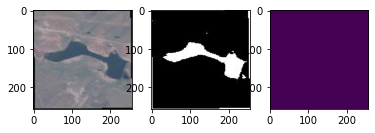

Epochs:1
Train_loss --> Dice: 0.6295934585854411 BCE: 0.6614966930821538 IoU: 0.6042214846704155 
Valid_loss --> Dice: 0.6394492768579059 BCE: 0.6515194343196021 IoU: 0.6265563004546695


100%|██████████| 36/36 [00:05<00:00,  6.31it/s]


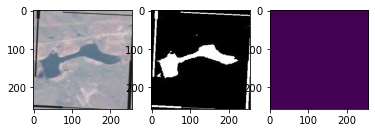

Epochs:2
Train_loss --> Dice: 0.6360466977581382 BCE: 0.6524872554466128 IoU: 0.6120408535003662 
Valid_loss --> Dice: 0.6388050350877974 BCE: 0.6513436916801665 IoU: 0.6249364001883401


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]


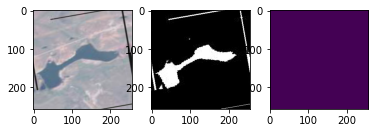

Epochs:3
Train_loss --> Dice: 0.6358037244528532 BCE: 0.6524296021088958 IoU: 0.6116987466812134 
Valid_loss --> Dice: 0.6396095736159219 BCE: 0.6508807755178876 IoU: 0.6259815212753084


100%|██████████| 36/36 [00:06<00:00,  5.68it/s]


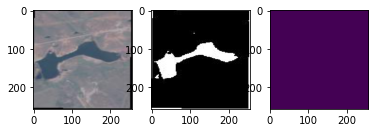

Epochs:4
Train_loss --> Dice: 0.6356693776324391 BCE: 0.6523430779576301 IoU: 0.6116988301277161 
Valid_loss --> Dice: 0.63962146308687 BCE: 0.6507102847099304 IoU: 0.626241428984536


100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


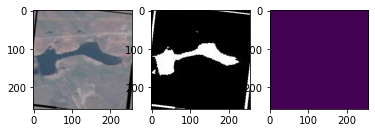

Epochs:5
Train_loss --> Dice: 0.6358704140409828 BCE: 0.6519404333084822 IoU: 0.6119986772537231 
Valid_loss --> Dice: 0.6392744365665648 BCE: 0.6505736062924067 IoU: 0.6257892615265317


100%|██████████| 36/36 [00:06<00:00,  5.89it/s]


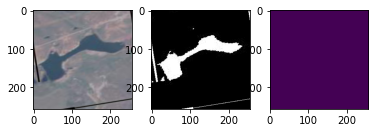

Epochs:6
Train_loss --> Dice: 0.635142283886671 BCE: 0.6521041557192803 IoU: 0.6113142013549805 
Valid_loss --> Dice: 0.6392360478639603 BCE: 0.6502611272864871 IoU: 0.6267575158013238


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]


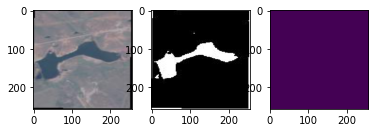

Epochs:7
Train_loss --> Dice: 0.6350860623642802 BCE: 0.6512363700196147 IoU: 0.6116771101951599 
Valid_loss --> Dice: 0.6390487005313238 BCE: 0.649168559246593 IoU: 0.6270203805632062


100%|██████████| 36/36 [00:06<00:00,  5.95it/s]


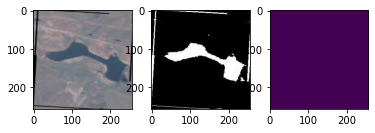

Epochs:8
Train_loss --> Dice: 0.6340991785749793 BCE: 0.6486241318285465 IoU: 0.6120316624641419 
Valid_loss --> Dice: 0.6366002791457706 BCE: 0.643962562084198 IoU: 0.6267487522628572


100%|██████████| 36/36 [00:05<00:00,  6.15it/s]


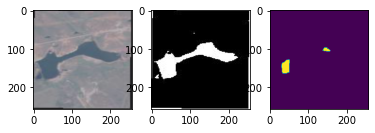

Epochs:9
Train_loss --> Dice: 0.6230748085305094 BCE: 0.6214187077246607 IoU: 0.6148712476715446 
Valid_loss --> Dice: 0.5826345731814703 BCE: 0.5542459744546149 IoU: 0.6430261350340314


100%|██████████| 36/36 [00:06<00:00,  5.99it/s]


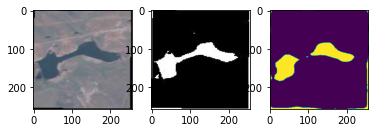

Epochs:10
Train_loss --> Dice: 0.5237980781123042 BCE: 0.5543363641016186 IoU: 0.6100089335930534 
Valid_loss --> Dice: 0.4902719838751687 BCE: 0.5778186983532376 IoU: 0.5976493168208334


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]


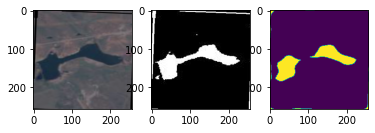

Epochs:11
Train_loss --> Dice: 0.48973203636705875 BCE: 0.546982862148434 IoU: 0.617861396400258 
Valid_loss --> Dice: 0.48115184406439465 BCE: 0.5258415010240343 IoU: 0.6416830064521896


100%|██████████| 36/36 [00:05<00:00,  6.09it/s]


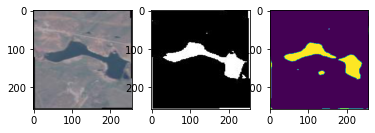

Epochs:12
Train_loss --> Dice: 0.47261878103017807 BCE: 0.5312301117926836 IoU: 0.6270609331317246 
Valid_loss --> Dice: 0.4654635538657506 BCE: 0.5003508114152484 IoU: 0.6662417931689156


100%|██████████| 36/36 [00:06<00:00,  5.94it/s]


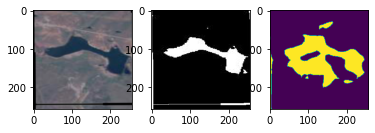

Epochs:13
Train_loss --> Dice: 0.4485991453751922 BCE: 0.5167377119883895 IoU: 0.6372286955825984 
Valid_loss --> Dice: 0.4302994691663318 BCE: 0.4735598961512248 IoU: 0.6735861011677318


100%|██████████| 36/36 [00:06<00:00,  5.35it/s]


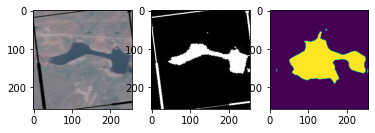

Epochs:14
Train_loss --> Dice: 0.42407886032015085 BCE: 0.4931157110258937 IoU: 0.6596961828880012 
Valid_loss --> Dice: 0.4285044703218672 BCE: 0.4529726795024342 IoU: 0.6944947441418966


100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


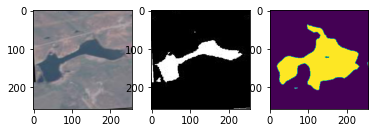

Epochs:15
Train_loss --> Dice: 0.41768021043390036 BCE: 0.48538956670090555 IoU: 0.6670807939954102 
Valid_loss --> Dice: 0.42244471775160897 BCE: 0.45112472358677125 IoU: 0.69740163286527


100%|██████████| 36/36 [00:05<00:00,  6.08it/s]


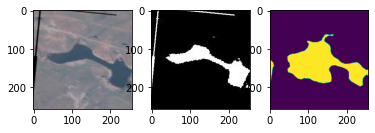

Epochs:16
Train_loss --> Dice: 0.41327489390969274 BCE: 0.4782527781557292 IoU: 0.6763221178203821 
Valid_loss --> Dice: 0.4001908434761895 BCE: 0.4502492505643103 IoU: 0.6983068601952659


100%|██████████| 36/36 [00:05<00:00,  6.06it/s]


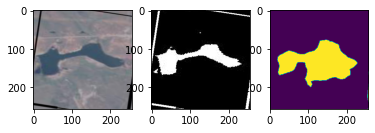

Epochs:17
Train_loss --> Dice: 0.4081421399489045 BCE: 0.4723412194289267 IoU: 0.682286449149251 
Valid_loss --> Dice: 0.40549860894680023 BCE: 0.44037773129012847 IoU: 0.7008511672417322


100%|██████████| 36/36 [00:06<00:00,  5.67it/s]


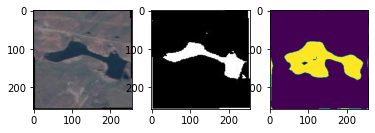

Epochs:18
Train_loss --> Dice: 0.40554824732244016 BCE: 0.4678357117343694 IoU: 0.6857527637854218 
Valid_loss --> Dice: 0.3873872872855928 BCE: 0.42714670300483704 IoU: 0.713383576936192


100%|██████████| 36/36 [00:06<00:00,  5.35it/s]


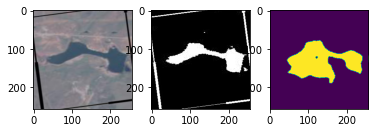

Epochs:19
Train_loss --> Dice: 0.3997406367212534 BCE: 0.46592304422520103 IoU: 0.6881849348545075 
Valid_loss --> Dice: 0.3975001937813229 BCE: 0.4170515123340819 IoU: 0.7214565310213301


100%|██████████| 36/36 [00:06<00:00,  5.77it/s]


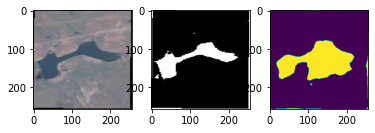

Epochs:20
Train_loss --> Dice: 0.3936140909790993 BCE: 0.45720530292019246 IoU: 0.6942543540149927 
Valid_loss --> Dice: 0.3861951066388024 BCE: 0.41935614662037957 IoU: 0.7157015668021308


100%|██████████| 36/36 [00:07<00:00,  5.04it/s]


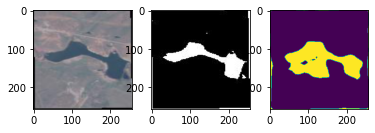

Epochs:21
Train_loss --> Dice: 0.39394129291176794 BCE: 0.4595363917760551 IoU: 0.6955138719640672 
Valid_loss --> Dice: 0.3864538305335575 BCE: 0.41767817611495656 IoU: 0.7220228711764017


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]


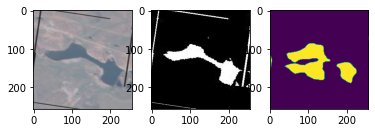

Epochs:22
Train_loss --> Dice: 0.38783641569316385 BCE: 0.45255578253418205 IoU: 0.6988825485110283 
Valid_loss --> Dice: 0.37984538575013477 BCE: 0.4088733237650659 IoU: 0.7300715810722775


100%|██████████| 36/36 [00:06<00:00,  5.54it/s]


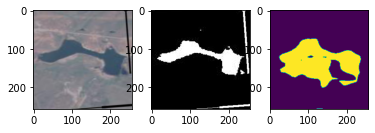

Epochs:23
Train_loss --> Dice: 0.3841569473966956 BCE: 0.45188153721392155 IoU: 0.7007255401462317 
Valid_loss --> Dice: 0.38850093715720707 BCE: 0.39890988419453305 IoU: 0.7362851152817408


100%|██████████| 36/36 [00:06<00:00,  5.40it/s]


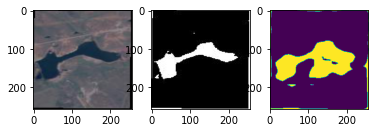

Epochs:24
Train_loss --> Dice: 0.3789536377415061 BCE: 0.4443586737848818 IoU: 0.7058383679948748 
Valid_loss --> Dice: 0.38537347979015774 BCE: 0.4075416839785046 IoU: 0.7369372066524293


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]


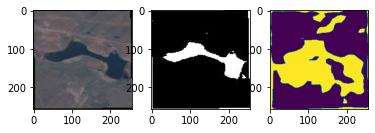

Epochs:25
Train_loss --> Dice: 0.3766632376238704 BCE: 0.4424682098440826 IoU: 0.7067067397758364 
Valid_loss --> Dice: 0.39415526390075684 BCE: 0.43409746057457393 IoU: 0.7081013437774446


100%|██████████| 36/36 [00:07<00:00,  5.08it/s]


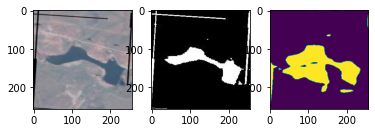

Epochs:26
Train_loss --> Dice: 0.3702527515590191 BCE: 0.4384931139182299 IoU: 0.7119916088879108 
Valid_loss --> Dice: 0.36743446191151935 BCE: 0.382679114325179 IoU: 0.7445307258102629


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]


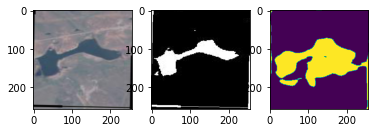

Epochs:27
Train_loss --> Dice: 0.36316315587610004 BCE: 0.42957281530834734 IoU: 0.7166939578019083 
Valid_loss --> Dice: 0.35692983037895626 BCE: 0.3957460920015971 IoU: 0.7360842062367333


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]


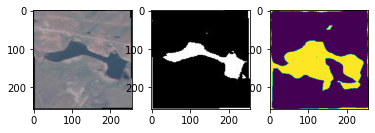

Epochs:28
Train_loss --> Dice: 0.3576230201870203 BCE: 0.42369424444623294 IoU: 0.7210663075558841 
Valid_loss --> Dice: 0.35598087973064846 BCE: 0.38743232521745896 IoU: 0.7440884957710902


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]


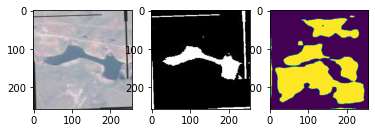

Epochs:29
Train_loss --> Dice: 0.3560211228206754 BCE: 0.4204186486080289 IoU: 0.7226639507338405 
Valid_loss --> Dice: 0.3608351879649692 BCE: 0.4192819959587521 IoU: 0.7249688771035936


100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


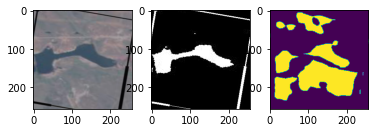

Epochs:30
Train_loss --> Dice: 0.34558256547898053 BCE: 0.41125181657262144 IoU: 0.7299958048388362 
Valid_loss --> Dice: 0.37747274173630607 BCE: 0.3697683248254988 IoU: 0.7513939638932546


100%|██████████| 36/36 [00:05<00:00,  6.11it/s]


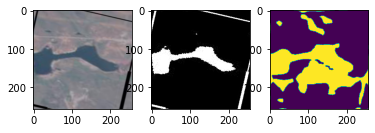

Epochs:31
Train_loss --> Dice: 0.33995786067098377 BCE: 0.4059452585410327 IoU: 0.7317294922657311 
Valid_loss --> Dice: 0.33595819274584454 BCE: 0.40317506881223786 IoU: 0.7356177551878823


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]


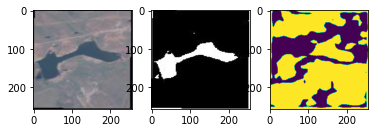

Epochs:32
Train_loss --> Dice: 0.3385124519467354 BCE: 0.4051961774472147 IoU: 0.7322933812625706 
Valid_loss --> Dice: 0.37740333875020343 BCE: 0.4404793381690979 IoU: 0.7090027332305908


100%|██████████| 36/36 [00:05<00:00,  6.40it/s]


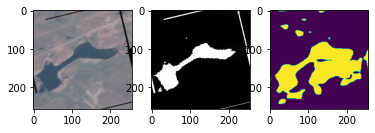

Epochs:33
Train_loss --> Dice: 0.3357143718749285 BCE: 0.40258395825512705 IoU: 0.7349172372370958 
Valid_loss --> Dice: 0.333346802327368 BCE: 0.38743096631434226 IoU: 0.7452590846353107


100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


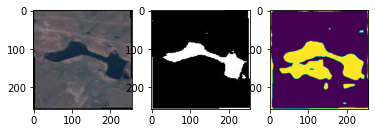

Epochs:34
Train_loss --> Dice: 0.33074950966984035 BCE: 0.39659375199116764 IoU: 0.7371866427361965 
Valid_loss --> Dice: 0.3508227417866389 BCE: 0.37402939879231983 IoU: 0.7514716221226586


100%|██████████| 36/36 [00:05<00:00,  6.10it/s]


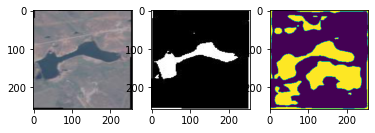

Epochs:35
Train_loss --> Dice: 0.32544801607728 BCE: 0.3913659925572574 IoU: 0.7400140001438558 
Valid_loss --> Dice: 0.3439883374505573 BCE: 0.3626751767264472 IoU: 0.7540456040038003


100%|██████████| 36/36 [00:05<00:00,  6.01it/s]


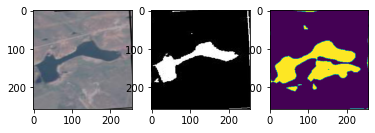

Epochs:36
Train_loss --> Dice: 0.328504198230803 BCE: 0.3959312405902892 IoU: 0.7383134328760207 
Valid_loss --> Dice: 0.346951973107126 BCE: 0.35766710134016144 IoU: 0.7584820406304466


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]


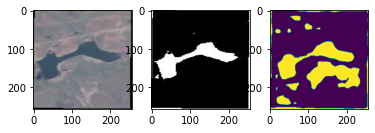

Epochs:37
Train_loss --> Dice: 0.32370576951652763 BCE: 0.3886701807845384 IoU: 0.7420180748216808 
Valid_loss --> Dice: 0.34535396264659035 BCE: 0.34514958701199955 IoU: 0.7627402908272214


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]


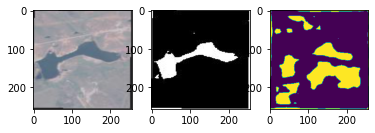

Epochs:38
Train_loss --> Dice: 0.32351340167224407 BCE: 0.389656850323081 IoU: 0.7418624577112496 
Valid_loss --> Dice: 0.3470064302285512 BCE: 0.3500173149837388 IoU: 0.7616152763366699


100%|██████████| 36/36 [00:05<00:00,  6.00it/s]


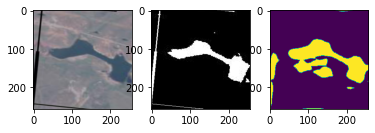

Epochs:39
Train_loss --> Dice: 0.3194004325196147 BCE: 0.385489605832845 IoU: 0.7437322994694113 
Valid_loss --> Dice: 0.33256058726045823 BCE: 0.3589497014052338 IoU: 0.7598972237772412


100%|██████████| 36/36 [00:06<00:00,  5.85it/s]


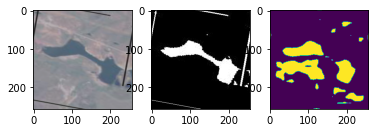

Epochs:40
Train_loss --> Dice: 0.318385087326169 BCE: 0.3839011689648032 IoU: 0.7451567226089537 
Valid_loss --> Dice: 0.33059829970200855 BCE: 0.3498441047138638 IoU: 0.7635947995715671


100%|██████████| 36/36 [00:06<00:00,  5.54it/s]


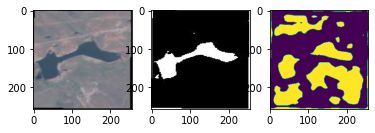

Epochs:41
Train_loss --> Dice: 0.321707914583385 BCE: 0.3866320534143597 IoU: 0.7431567432358861 
Valid_loss --> Dice: 0.3648157881365882 BCE: 0.4020073033041424 IoU: 0.7303997725248337


100%|██████████| 36/36 [00:06<00:00,  5.75it/s]


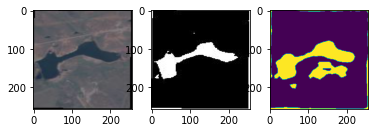

Epochs:42
Train_loss --> Dice: 0.31999936513602734 BCE: 0.3852212720550597 IoU: 0.7442871374078095 
Valid_loss --> Dice: 0.34919529325432247 BCE: 0.3510981487731139 IoU: 0.7621542596154742


100%|██████████| 36/36 [00:06<00:00,  5.68it/s]


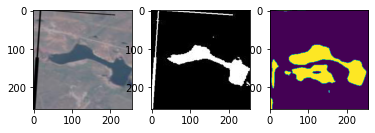

Epochs:43
Train_loss --> Dice: 0.31505811139941214 BCE: 0.3822445260360837 IoU: 0.7470549559220672 
Valid_loss --> Dice: 0.3508409394158257 BCE: 0.35488250106573105 IoU: 0.7611386196480857


100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


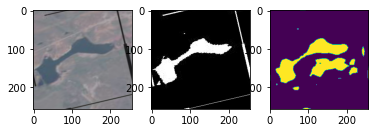

Epochs:44
Train_loss --> Dice: 0.3148530988022685 BCE: 0.3794092785101384 IoU: 0.7466361159458756 
Valid_loss --> Dice: 0.34227846893999314 BCE: 0.346150192949507 IoU: 0.761237793498569


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]


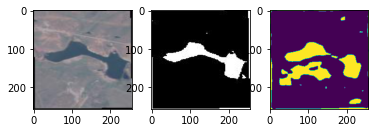

Epochs:45
Train_loss --> Dice: 0.30998354181647303 BCE: 0.3766456331126392 IoU: 0.7495308899320662 
Valid_loss --> Dice: 0.338100822435485 BCE: 0.34044443402025437 IoU: 0.7634472002585729


In [22]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

dice_train_losses = []
dice_val_losses = []
train_iou_scores = []
valid_iou_scores = []
for i in range(45):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce,train_iou=train_loss
    valid_dice,valid_bce,valid_iou=valid_loss
    dice_train_losses.append(train_dice)
    dice_val_losses.append(valid_dice)
    train_iou_scores.append(train_iou)
    valid_iou_scores.append(valid_iou)
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} IoU: {train_iou} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce} IoU: {valid_iou}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        #torch.save(model.state_dict(),'best_model_fcn8s.pt')
        #print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce
torch.save(model.state_dict(),'best_model_fcn8s_no_vgg_45.pt')

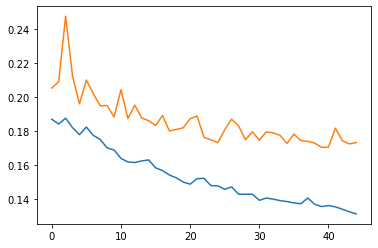

In [41]:
import matplotlib.pyplot as plt
plt.plot(dice_train_losses)
plt.plot(dice_val_losses)
plt.show()

In [ ]:
#torch.save(model.state_dict(),'best_model_fcn8s_45.pt')

In [ ]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model_fcn8s_45.pt'))

image,mask=valid_loader.dataset[5]
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))